In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Advanced Deep Learning

# Lab: 2 Robustness in Deep Learning

The material of this lab is almost entirely based on the first part of chapter 1 of a public tutorial authored by **Zico Kolter** and **Aleksander Madry** available [here](https://adversarial-ml-tutorial.org/introduction/). 


## Introduction

As we seek to deploy machine learning systems not only on virtual domains, but also in real systems, it becomes critical that we examine not only whether the systems don't simply work "most of the time", but which are truly robust and reliable.  Although many notions of robustness and reliability exist, one particular topic in this area that has raised a great deal of interest in recent years is that of adversarial robustness: can we develop classifiers that are robust to (test time) perturbations of their inputs, by an adversary intent on fooling the classifier?  This is of course a very specific notion of robustness in general, but one that seems to bring to the forefront many of the deficiencies facing modern machine learning systems, especially those based upon deep learning.

This tutorial seeks to provide a broad, hands-on introduction to this topic of adversarial robustness in deep learning.  The goal is combine both a mathematical presentation and illustrative code examples that highlight some of the key methods and challenges in this setting. Although we try to touch on most of the high-level ideas that have been driving research in this area of work, it is certain that we will also omit some highly relevant work.  

### Logistics
The code in this notebook relies on Python 3.7 (though should be compatible with 3.6), and makes use of the following libraries:
  - [pytorch 1.0](https://pytorch.org)
  - [cvxpy 1.0](http://cvxpy.org)
  - numpy/scipy/PIL/etc

Ideally, the precise version number should not matter, and the approach should be compatible with e.g. pytorch 0.4.x (but not earlier), earlier versions of pillow, etc.  We installed all this software by with a fresh install of [Anaconda](https://www.anaconda.com/) (which includes all of the needed libraries except PyTorch and cvxpy), then used the `conda install <package>` or `pip install <package>` commands to install all the relevant software.  We also provide a docker container capable of running all the notebooks in our github repository.  You will only need cvxpy for some of the optimization-related approaches we discuss, and most of the tutorial can be done without this tool, but PyTorch is used quite heavily throughout.

Many of the simpler examples are quite fast to compute, and so we just implement them on a CPU.  For the more time-intensive operations, however (especially the various types of adverarial training), it is necessary to train the systems on a GPU to have any hope of being computationally efficient.  Thus, in order to run these later examples, you will also need CUDA installed with the above version of PyTorch.

## Diving right in

One of the beautiful things about deep learning is just how easy it is to jump right in and start seeing some actual results on real data.  With that mindset, let's start off by constructing our very first adversarial example.  We will introduce a very small amount of mathematical notation here, which will be substantially expanded upon shortly, and the actual technique we use here is not the ultimate strategy that we will use, but it is fairly close in spirit, and actually captures most of the basic components that we will see later.

To start off, let's use the (pre-trained) ResNet50 model within PyTorch to classify this picture of a pig.

!['Show Pig' licensed under CC BY 2.0](pig.jpg)

The normal strategy for image classification in PyTorch is to first transform the image (to approximately zero-mean, unit variance) using the `torchvision.transforms` module.  However, because we'd like to make perturbations in the original (unnormalized) image space, we'll take a slightly different approach and actually build the transformations at PyTorch layers, so that we can directly feed the image in.  First, let's just load the image and resize the 224x224, which is the default size that most ImageNet images (and hence the pre-trained classifiers) take as input.

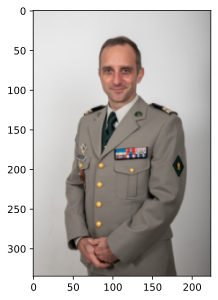

In [35]:
from PIL import Image
from torchvision import transforms

# read the image, resize to 224 and convert to PyTorch Tensor
pig_img = Image.open("Thomas.jpg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
pig_tensor = preprocess(pig_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(pig_tensor[0].numpy().transpose(1,2,0))
plt.show()

Now let's load the pre-trained ResNet50 model and apply it to the image, after necessary transforms (the weird indexing here is just used to comply with PyTorch standards that all inputs to modules should be of the form `batch_size x num_channels x height x width`).

In [36]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();

C:\Users\gabri\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\gabri\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
# form predictions
pred = model(norm(pig_tensor))

Pred now contains a 1000 dimensional vector containing the class logits for the 1000 imagenet classes (i.e., if you wanted to convert this to a probability vector, you would apply the softmax operator to this vector).  To find the highest likelihood class, we simply take the index of maximum value in this vector, and we can look this up in a list of imagenet classes to find the corresponding label.

In [38]:
import json
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
print(imagenet_classes[pred.max(dim=1)[1].item()])

military_uniform


Loooking good! (note that ImageNet has one class correpsonding to both "hog" and "pig", so this is the correct label).  We should note that this is the first pig image we tried here, so it doesn't take any tweaking to get a result like this ... modern image classifiers are pretty impressive.

### Some introductory notation
Now let's try to fool this classifier into thinking this image of a pig is something else.  To explain this process, we're going to introduce a bit more notation.  Specifically, we'll define the define the model, or hypothesis function, $h_\theta : \mathcal{X} \rightarrow \mathbb{R}^k$ as the mapping from input space (in the above example this would be a three dimensional tensor), to the output space, which is a $k$-dimensional vector, where $k$ is the number of classes being predicted; note that like in our model above, the output corresponds to the logit space, so these are real-valued numbers that can be positive or negative.  The $\theta$ vector represents all the parameters defining this model, (i.e., all the convolutional filters, fully-connected layer weight matrices, baises, etc); the $\theta$ parameters are what we typically optimize over when we train a neural network.  And finally, note that this $h_\theta$ corresponds precisely the `model` object in the Python code above.

Second, we define a loss function $\ell: \mathbb{R}^k \times \mathbb{Z}_+ \rightarrow \mathbb{R}_+$ as a mapping from the model predictions and true labels to a non-negative number.  The semantics of this loss function are that the first argument is the model output (logits which can be positive or negative), and the second argument is the _index_ of the true class (that is, a number from 1 to $k$ denoting the index of the true label). Thus, the notation
\begin{equation}
\ell(h_\theta(x), y)
\end{equation}
for $x \in \mathcal{X}$ the input and $y \in \mathbb{Z}$ the true class, denotes the loss that the classifier achieves in its predictions on $x$, assuming the true class is $y$.  By far the most common form of loss used in deep learning is the cross entropy loss (also sometimes called the softmax loss), defined as
\begin{equation}
\ell(h_\theta(x), y) = \log \left ( \sum_{j=1}^k \exp(h_\theta(x)_j) \right ) - h_\theta(x)_y
\end{equation}
where $h_\theta(x)_j$ denotes the $j$th elements of the vector $h_\theta(x)$.

**Aside:** For those who are unfamiliar with the convention above, note that the form of this loss function comes from the typical softmax activation.  Defining the softmax operator $\sigma : \mathbb{R}^k \rightarrow \mathbb{R}^k$ applied to a vector
\begin{equation}
\sigma(z)_i = \frac{exp(z_i)}{\sum_{j=1}^{k}\exp(z_{j})}
\end{equation}
to be a mapping from the class logits returned by $h_\theta$ to a probability distribution.  Then the typical goal of training a network is to maximize the probability of the true class label.  Since probabilities themselves get vanishingly small, it is more common to maximize the _log_ of the probability of the true class label, which is given by
\begin{equation}
\log \sigma(h_\theta(x))_y = \log \left(\frac{exp(h_\theta(x)_y)}{\sum_{j=1}^{k}\exp(h_\theta(x)_{j})} \right) = h_\theta(x)_y - \log \left (\sum_{j=1}^{k}\exp(h_\theta(x)_{j}) \right ).
\end{equation}
Since the convention is that we want to _minimize_ loss (rather than maximizing probability), we use the negation of this quantity as our loss function.  We can evaluate this loss in PyTorch using the following command.

In [39]:
# 341 is the class index corresponding to "hog"
print(nn.CrossEntropyLoss()(model(norm(pig_tensor)),torch.LongTensor([341])).item())

16.6992244720459


A loss of 0.0039 is pretty small: by the conventions above, that would correspond to an $\exp(-0.0039) \approx 0.996$ probability that the classifier believes this to be a pig.

### Creating an adversarial example
So how do we manipulate this image to make the classifier believe it is something else?  To answer this, note that by common approach to training a classifier is to optimize the _parameters_ $\theta$, so as to minimize the average loss over some training set $\{x_i \in \mathcal{X}, y_i \in \mathbb{Z}\}$, $i=1,\ldots,m$, which we write as the optimization problem
\begin{equation}
\operatorname{min}_\theta \frac{1}{m} \sum_{i=1}^m \ell(h_\theta(x_i), y_i)
\end{equation}
which we typically solve by (stochastic) gradient descent.  I.e., for some minibatch $\mathcal{B} \subseteq \{1,\ldots,m\}$, we compute the gradient of our loss with respect to the parameters $\theta$, and make a small adjustment to $\theta$ in this negative direction
\begin{equation}
\theta := \theta - \frac{\alpha}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \nabla_\theta \ell(h_\theta(x_i), y_i)
\end{equation}
where $\alpha$ is some step size, and we repeat this process for different minibatches covering the entire training set, until the parameters converge.

The key term of interest here is the gradient $\nabla_\theta \ell(h_\theta(x_i), y_i)$, which computes how a small adjustment to each the parameters $\theta$ will affect the loss function.  For deep neural networks, this gradient is computed efficiently via backpropagation.  However, the beauty of automatic differentiation (the mathematical technique that underlies backpropagation), is that we aren't just limited to differentiating the loss with respect to $\theta$; we can just as easily compute the gradient of the loss with respect to the input $x_i$ itself.  This quantity will tell us how small changes to the image itself affect the loss function.

This is exactly what we're going to do to form an adversarial example.  But instead of adjusting the image to minimize the loss, as we did when optimizing over the network parameters, we're going to adjust the image to _maximize_ the loss.  That is, we want to solve the optimization problem
\begin{equation}
\operatorname{max}_{\hat{x}} \ell(h_\theta(\hat{x}), y)
\end{equation}
where $\hat{x}$ denotes our adversarial example that is attempting to maximize the loss.  Of course, we cannot just optimize arbitrarily over $\hat{x}$ (there do exist, after all, some images that are _not_ pigs, and if we change the image entirely, say to a dog, then it's not particularly impressive that we can "fool" the classifier into thinking it's not a pig).  So we instead need to ensure that $\hat{x}$ is close to our original input $x$.  By convention, we typically do this by optimizing over the _perturbation_ to $x$, which we will denote $\delta$, and then by optimizing over $\delta$
\begin{equation}
\operatorname{max}_{\delta \in \Delta} \ell(h_\theta(x +\delta), y)
\end{equation}
where $\Delta$ represents an allowable set of perturbations.  Characterizing the "correct" set of allowable perturbations is actually quite difficult: in theory, we would like $\Delta$ to capture anything that humans visually feel to be the "same" as the original input $x$.  This can include anthing ranging from adding slight amounts of noise, to rotating, translating, scaling, or performing some 3D transformation on the underlying model, or even completely changing the image in the "non-pig" locations.  Needless to say, it is not possible to give a mathematically rigorous definition of all the perturbations that _should_ be allowed, but the philosophy behind adversarial examples is that we can consider some _subset_ of the possible space of allowed perturbations, such that by any "reasonable" definition, the actual semantic content of the image could not change under this perturbation.

A common perturbation set to use, though by no means the only reasonable choice, is the $\ell_\infty$ ball, defined by the set
\begin{equation}
\Delta = \{\delta : \|\delta\|_\infty \leq \epsilon\}
\end{equation}
where the $\ell_\infty$ norm a vector $z$ is defined as
\begin{equation}
\|z\|_\infty = \max_i |z_i|
\end{equation}
i.e., we allow the perturbation to have magnitude between $[-\epsilon, \epsilon]$ in each of its components (it is slightly more complex, as we also need to ensure that $x + \delta$ is also bounded between $[0,1]$ so that it is still a valid image).  We'll return later to debeate whether or not it is reasonable to consider the $\ell_\infty$ ball, or norm-balls in general as perturbation sets.  But all we will say for now is that the advantage of the $\ell_\infty$ ball is that for small $\epsilon$ it creates perturbations which add _such_ a small component to each pixel in the image that they are visually indistinguishable from the original image, and thus provide a "necessarily-but-definitely-not-close-to-sufficient" condition for us to consider a classifier robust to perturbations.  And the reality of deep networks is that they can very easily be fooled by manipulations precisely of this type.

Ok, enough discussion.  Let's see what this looks like in practice.  The following example uses PyTorch's `SGD` optimizer to adjust our perturbation to the input to maximize the loss.  Derspite the name, since there is no notion of a training set or minibatches here, this is not actually stochastic gradient descent, but just gradient descent; and since we follow each step with a projection back onto the $\ell_\infty$ ball (done by simply clipping the values that exceed $\epsilon$ magnitude to $\pm \epsilon$), this is actually a procedure known as projected gradient descent (PGD).  We'll shortly consider slightly more complex versions (where we'll need to things explicitly instead of using PyTorch's optimization class), but we'll keep things simple for now.

> **Coding Task 1:** In the below code cell we ask you to
> 1. obtain the predictions of the model on the normalised (using the above ```norm``` function) sum of the pig_tensor and our perturbation delta;
> 2. compute the loss to be the negative cross entropy loss of our predictions against the true class 341;
> 3. And then to perform the step wise optimisation by (3.1) zeroing out the gradients in the optimiser, (3.2) computing the gradients using the .backwards() subroutine of the loss and (3.3) taking a step in the optimiser.

In [17]:
import torch.optim as optim
epsilon = 2./255

delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)

for t in range(30):
    pred = model(norm(pig_tensor+delta))
    loss = nn.CrossEntropyLoss()(pred,torch.LongTensor([341]))
    if t % 5 == 0:
        print(t, loss.item())

    ### Please fill in 3.1-3.3 here
    opt.zero_grad()
    (-loss).backward()
    opt.step()
    
    delta.data.clamp_(-epsilon, epsilon)
    
print("True class probability:", nn.Softmax(dim=1)(pred)[0,341].item())

0 0.003882253309711814
5 0.006934622768312693
10 0.015797464177012444
15 0.0808233916759491
20 10.986251831054688
25 15.792571067810059
True class probability: 3.382620761271937e-08


After 30 gradient steps, the ResNet50 thinks that this has less than a $10^{-5}$ chance of being a pig.  (Note: we should also clip $x + \delta$ to be in $[0,1]$, but this already holds for any $\delta$ within the above bound, so we don't need to do it explicitly here).  Instead, it turns out that this classifier is quite sure the image is a wombat, as we can see from the following code, which computes the maximum class and its probability.

In [10]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  wombat
Predicted probability: 0.9999353885650635


So what does this wombat-pig look like?  Extremely similar to our original pig, unfortunately.

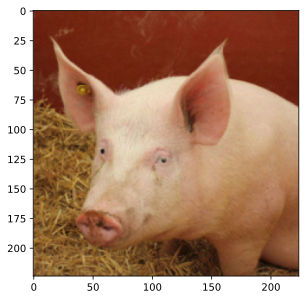

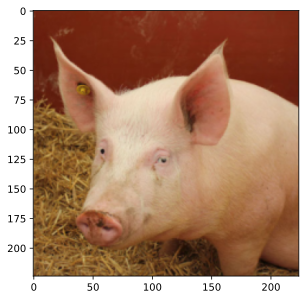

In [12]:
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))
plt.show()

plt.imshow(pig_tensor[0].numpy().transpose(1,2,0))
plt.show()

Here in fact is the `delta` we added to the image, heavily zoomed in by a factor of 50 because it would be impossible to see otherwise.

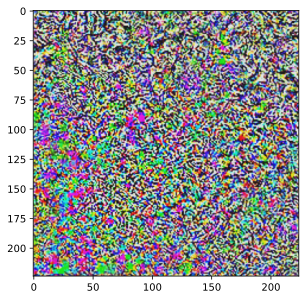

In [15]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))
plt.show()

So essentially, by adding a tiny multiple of this random-looking noise, we're able to create an image that looks identical to our original image, yet is classified very incorrectly.  Of course, to do all of this more correctly, we should quantize our noise to the allowable level of the image (i.e., to within steps of 1/255), but technicalities like this are easy to overcome, and we can indeed create valid images which are impossible for the human eye to distinguish between them and our original image, but which the classifier misclassifies.

### Targeted attacks
Ok, you might say.  This is impressive, but a wombat really isn't _that_ different from a pig, so maybe the problem isn't that bad.  But it turns out this same technique can be used to make the image classified as virtually any class we desire.  This is known as a "targeted attack", and the only difference is that instead of trying to just maximize the loss of the correct class, we maximize the loss of the correct class while also minimizing the loss of the target class.  That is, we solve the optimization problem
\begin{equation}
max_{\delta \in \Delta} \left (\ell(h_\theta(x +\delta), y) - \ell(h_\theta(x +\delta), y_{\mathrm{target}}) \right) \equiv max_{\delta \in \Delta} \left(h_\theta(x+\delta)_{y_{\mathrm{target}}} - h_\theta(x+\delta)_{y} ]\right )
\end{equation}
where the expression simplies because the $\log \left ( \sum_{j=1}^k \exp(h_\theta(x)_j) \right )$ terms from each loss cancel, and all that remains is the linear terms.  Here is how this looks.  Note that we tuned the step size a bit to make it work in this case, but we'll shortly consider slightly different scaling methods for projected gradient descent where this isn't needed.

> **Coding Task 2:** This task requires you to make use of your solution to task 1 for subparts 1. and 3.1-3.3. Only subpart 2 should be modified: We now want you to work with the loss that is computed as the negative cross entropy loss against class 341 summed onto the positive cross entropy loss for class 404.

In [40]:
delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)

for t in range(100):
    pred =  model(norm(pig_tensor+delta))
    loss = -nn.CrossEntropyLoss()(pred,torch.LongTensor([652])) + nn.CrossEntropyLoss()(pred,torch.LongTensor([404]))
    if t % 10 == 0:
        print(t, loss.item())

    ### Please fill in 3.1-3.3 here (as in Task 1)
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    delta.data.clamp_(-epsilon, epsilon)

0 16.847675323486328
10 4.722429275512695
20 -2.1148178577423096
30 -7.196430683135986
40 -18.109512329101562
50 -24.954025268554688
60 -31.718313217163086
70 -39.84886169433594
80 -40.98696517944336
90 -47.73003387451172


In [41]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  airliner
Predicted probability: 0.9999910593032837


As before, here's our airliner-pig, looking an awful lot like a normal pig (the target class of 404 from the code is indeed an airliner, so our targeted attack is working)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.007843138..0.99215686].


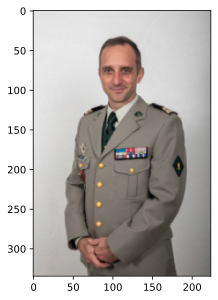

In [42]:
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))
plt.show()

And here is our airliner noise.

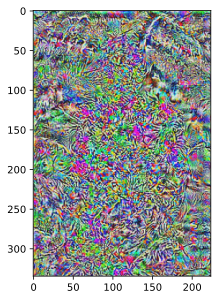

In [43]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))
plt.show()

The conclusion, of course, is that with adversarial attacks and deep learning, you can make pigs fly.  [Important note: this tutorial is written jointly by Zico and Aleksander, but this pun is Aleksander's.  Zico disavows any association with this one part of the tutorial.]

We'll discuss the practical questions that these attacks raise shortly, but the ease of such attacks raises an obvious question: can we train deep learning classifiers that are somehow resistant to such attacks?  The short answer to this question is "yes", but we (as a field) are a long way from really making such training practical, or achieving nearly the performance that we get with "standard" deep learning methods.  This tutorial will cover both the attack and the defense side in great detail, and hopefully by the end of it, you will get a sense of the current state of the art, as well as the directions where we still need to make substantial progress.

## Open End

I (Johannes) sincerely hope that you enjoyed this tutorial as much as I did. Adversarial robustness is a fun subdomain of deep learning in which theory and practice mix in a productive manner and I am glad I got to introduce it to you today. If you still have some additional time and want to spend it on this topic, then I have the following suggestions for you.


- You could continue following [Zico's and Aleksander's tutorial](https://adversarial-ml-tutorial.org/introduction/) by reading the general introduction at the end of their first chapter and then moving on to the remaining four chapters of their introduction.
- You could take a trained classifier from another course, context or project and see how easily you can attack it with the above techniques.
- Or you could watch the [great keynote talk](https://iclr.cc/virtual/2025/invited-talk/36782) that Zico gave in May 2025 at the ICLR conference to get an insight into the current academic discussion of robustness in Deep Learning as well as his perspective of the developments of this area over the past 10 years.    

